# 使用循环神经网络拟合sin函数
## 目标
- 给定函数值的第i ：i + time_step项作为输入,预测第i + time_step项（其中i从0:seq_len - time_step）
- 通过time_step项内容预测下一个内容

## 思路
- 定义超参数 ： 隐藏层，batch大小等
- 数据生成 ： 使用sin函数随机采样生成lable
- 构建LSTM为核心的网络结构
- batch训练
- 测试，拟合得到结果

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 超参数


In [2]:
Hidden_size = 30                                                           ## 隐藏层向量的维度
Num_Layers = 2                                                             ## 网络层数
TimeSteps = 10                                                             ## max_step_size 可以对应最长句子
Trainning_steps = 100000                                                    ## 训练的轮数
Batch_size = 32                                                            ## batch 大小
Training_examples = 10000                                                  ## 数据规模，采样大小
Test_examples = 1000                                                       ## 测试集数据规模
Sample_Gap = 0.1                                                          ## 间隔采样数

In [3]:
def generate_data(seq):
    '''
    :parm seq: 一段sin函数序列，在基础的RNN结构中一般是一段文本序列
    :return:向量化的X与Y，其中X是输入，Y是需要预测的lable
    '''
    x = []
    y = []
    for i in range(len(seq) - TimeSteps):
        x.append([seq[i:i+TimeSteps]])
        y.append([seq[i+TimeSteps]])
    return np.array(x,dtype = np.float32),np.array(y,dtype = np.float32)

In [4]:
def build_model(X,Y,is_training):
    '''
    :parm X:训练集
    :parm Y:lable标签
    :parm istraining:模型是否是用于训练
    :return:训练优化步骤，loss，预测值
    '''
    cell = tf.nn.rnn_cell.MultiRNNCell([
        tf.nn.rnn_cell.BasicLSTMCell(Hidden_size)
        for _ in range(Num_Layers)
    ])
    ##多层rnn,多层指的是纵向的rnn层，的写法
    
    ##前向传播
    
    outputs,_ = tf.nn.dynamic_rnn(cell,X,dtype = tf.float32)
    ##其中，_为输出的当前的状态state，用于传到下一时刻，本目标无需用到此参数，并且我们只取最后一次的输出即可
    ##output 维度 [batch_size,time,hidden_size] 
    output = outputs[:,-1,:]
    
    ##平方差损失
    
    predictions = tf.contrib.layers.fully_connected(output,1,activation_fn = None)
    
    ##测试只返回预测
    
    if not is_training:
        return predictions,None,None
    
    ##计算损失函数
    
    loss = tf.losses.mean_squared_error(labels= Y,predictions=predictions)
    
    ##创建优化器，得到优化步骤
    
    train_op = tf.contrib.layers.optimize_loss(
        loss,tf.train.get_global_step(),
        optimizer = "Adagrad",learning_rate = 0.1)
    
    ##训练返回
    return predictions,loss,train_op

In [5]:
def train(sess,train_X,train_Y):
    '''
    将数据提供给图,进行训练
    '''
    
    ds = tf.data.Dataset.from_tensor_slices((train_X,train_Y))
    ds = ds.repeat().shuffle(1000).batch(Batch_size)##数据集的一些预处理
    
    X,y = ds.make_one_shot_iterator().get_next()
    
    with tf.variable_scope("model"):
        predictions,loss,train_op = build_model(X,y,True) ##这里使用placeholder，feed_dict也是一样的，这里模型构建成功
    sess.run(tf.global_variables_initializer())##参数初始化
    for i in range(Trainning_steps):
        _,l = sess.run([train_op,loss])
        if i % 1000 == 0 :
            print("train step: " + str(i) +" , loss: " + str(l))

In [6]:
def evall(sess,test_X,test_Y):
    '''
    数据测试，并且图形显示
    '''
    ds = tf.data.Dataset.from_tensor_slices((test_X,test_Y))
    ds = ds.batch(1)
    X,y = ds.make_one_shot_iterator().get_next()
    
    with tf.variable_scope("model",reuse = True):##注意这里需要重新使用 model scope下的参数
        predictions,_,_ = build_model(X,[0.0],False) ##这里使用placeholder，feed_dict也是一样的，这里模型构建成功
    
    predict = []
    lables = []
    
    for i in range(Test_examples):
        p,l = sess.run([predictions,y])
        predict.append(p)
        lables.append(l)##真实的y
        ##注意 这里predictions，y都是初始化的图的部件，逻辑，只有run之后才会变成数据，向量
    # 计算rmse作为评价标准
    predictnp = np.array(predict).squeeze()
    lablesnp = np.array(lables).squeeze()##squeeze移除长度为1的轴
    
#     print(predictnp)
#     print(lablesnp)
#     print((predictnp - lablesnp)**2)
    
    rmse = np.sqrt(((predictnp - lablesnp)**2).mean())##这里变成一个常数
    
    print("rmse is "+ str(rmse))
    
    plt.figure()
    plt.plot(predictnp,label  = 'predictions')
    plt.plot(lablesnp,label  = 'real_lable')
    plt.legend()
    plt.show()

### program 接口

In [7]:
test_start  = (Training_examples + TimeSteps) * Sample_Gap
test_end = test_start + (Test_examples + TimeSteps)*Sample_Gap

##np.linspace:用于产生等差数列,第三个参数代表序列长度
train_x , train_y = generate_data(
    np.sin(np.linspace(0,test_start,Training_examples + TimeSteps,dtype=np.float32))
)

test_x , test_y = generate_data(
    np.sin(np.linspace(test_start,test_end,Training_examples + TimeSteps,dtype=np.float32))
)

train step: 0 , loss: 0.528215
train step: 1000 , loss: 0.000215865
train step: 2000 , loss: 6.70109e-05
train step: 3000 , loss: 1.51195e-05
train step: 4000 , loss: 7.19506e-06
train step: 5000 , loss: 2.89827e-06
train step: 6000 , loss: 2.57569e-06
train step: 7000 , loss: 2.17753e-06
train step: 8000 , loss: 2.19302e-06
train step: 9000 , loss: 1.83319e-06
train step: 10000 , loss: 2.19135e-06
train step: 11000 , loss: 1.49554e-06
train step: 12000 , loss: 1.55781e-06
train step: 13000 , loss: 1.88273e-06
train step: 14000 , loss: 1.54034e-06
train step: 15000 , loss: 1.64316e-06
train step: 16000 , loss: 1.53196e-06
train step: 17000 , loss: 1.90939e-06
train step: 18000 , loss: 1.60672e-06
train step: 19000 , loss: 1.33443e-06
train step: 20000 , loss: 1.4187e-06
train step: 21000 , loss: 1.29882e-06
train step: 22000 , loss: 1.02493e-06
train step: 23000 , loss: 1.12092e-06
train step: 24000 , loss: 1.1441e-06
train step: 25000 , loss: 1.15724e-06
train step: 26000 , loss: 1.22

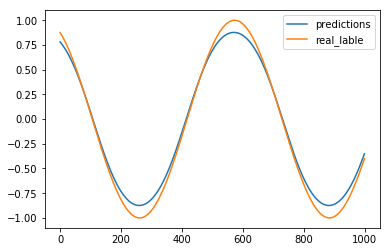

In [8]:
with tf.Session() as sess:
    train(sess,train_x,train_y)
    evall(sess,test_x,test_y)